   # Predicting Interview Attendance

The Interview Attendance problem on Kaggle uses data collected by Indian academics. The data can be found [here](https://www.kaggle.com/vishnusraghavan/the-interview-attendance-problem).

The problem is a binary classification one - potential interview attendees either attended or they didn't. Our aim here is to predict whether they attend or not, based on the independent features provided (demographic data plus answers to some surveys). I will use this as an opportunity to test out multiple classification algorithms, and ensemble methods to try and predict whether a interviwee attends. 

## Contents:

1. [TLDR](#TLDR)
2. [The Data](#The_Data)
3. [Data Exploration](#Data_Exp)
4. [Classification](#Classification)
    1. [Decision Trees](#DT)
    2. [Random Forest](#RF)
    3. [XGBoost](#XG)
    4. [K Nearest Neighbours](#KNN)
    5. [Naive Bayes](#NB)
    6. [Support Vector Machines](#SVM)
5. [Further Work](#Further_Work)

<a id='TLDR'></a>

## TLDR

We tried a number of number of preprocessing techniques and a number of classification algorithms, evaluating them by their accuracy. The XGBoost ensemble method produced the best results. However this algorithm takes the longest to train, so depending on use case, may still not be the favoured one! 

Overall accuracy achieved: 74.35%

The best feature by itself was the 'expected attendance' feature. This produced around 60% accuracy on its own. So there would be scope for reviewing the questions asked to see if we could improve the data flowing into the models. 

<a id='The_Data'></a>

   ## The Data

Import the data and show the first 5 rows.

In [72]:
import pandas as pd

df = pd.read_csv('Interview.csv')
df = df[df.columns[:-5]]
df.head()

,Date of Interview,Client name,Industry,Location,Position to be closed,Nature of Skillset,Interview Type,Name(Cand ID),Gender,Candidate Current Location,...,Have you obtained the necessary permission to start at the required time,Hope there will be no unscheduled meetings,Can I Call you three hours before the interview and follow up on your attendance for the interview,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much,Have you taken a printout of your updated resume. Have you read the JD and understood the same,Are you clear with the venue details and the landmark.,Has the call letter been shared,Expected Attendance,Observed Attendance,Marital Status
0,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 1,Male,Chennai,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Single
1,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 2,Male,Chennai,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Single
2,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 3,Male,Chennai,...,NaN,Na,NaN,NaN,NaN,NaN,NaN,Uncertain,No,Single
3,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 4,Male,Chennai,...,Yes,Yes,No,Yes,No,Yes,Yes,Uncertain,No,Single
4,13.02.2015,Hospira,Pharmaceuticals,Chennai,Production- Sterile,Routine,Scheduled Walkin,Candidate 5,Male,Chennai,...,Yes,Yes,Yes,No,Yes,Yes,Yes,Uncertain,No,Married


The column titles need tidying up

In [73]:
df.columns = ['Interview_Date', 'Client', 'Industry', 'Location',
       'Position', 'Skillset', 'Interview_Type',
       'Cand_ID', 'Gender', 'Candidate_Current_Location',
       'Candidate_Job_Location', 'Interview_Venue',
       'Candidate_Native_location',
       'Permission_acquired',
       'No_unscheduled',
       'Call_before_and_follow_up',
       'Extra_phone_number',
       'Got_CV_and_read_JD',
       'Clear_on_venue',
       'Letter_shared', 'Expected_Attendance',
       'Observed_Attendance', 'Marital_Status']

In [74]:
#Helper function to clean up the dates column
def clean_date(date):
    date = date.str.strip()
    date = date.str.split("&").str[0]
    date = date.str.replace('–', '/')
    date = date.str.replace('.', '/')
    date = date.str.replace('Apr', '04')
    date = date.str.replace('-', '/')
    date = date.str.replace(' ', '/')
    date = date.str.replace('//+', '/')
    return date

In [75]:
#Further work to clean up the dates column and turn it into a Date Object
df['Interview_Date'] = clean_date(df['Interview_Date'])
df['year'] = df['Interview_Date'].str.split("/").str[2]
df['day'] = df['Interview_Date'].str.split("/").str[0]
df['month'] = df['Interview_Date'].str.split("/").str[1]

# This will find the short years and replace with long years
df['year'].replace(['16', '15'], ['2016', '2015'], inplace = True)

#And now can create proper date column
df['date'] = pd.to_datetime(pd.DataFrame({'year': df['year'],
                                            'month': df['month'],
                                            'day': df['day']}), format = '%Y-%m-%d')

In [76]:
#now drop temporary date columns so I just have 'day of week', which is the only one likely to give additional information
df.drop(['Interview_Date', 'year', 'month', 'day'], axis = 1, inplace = True)
df['Day_of_Week'] = df.date.dt.dayofweek

In [77]:
#review all columns to see unique values
for column in df.columns:
    print(column, df[column].unique())
    print('-'*40)

Client ['Hospira' 'Aon Hewitt' 'UST' 'Standard Chartered Bank' 'ANZ' 'Pfizer'
 'Standard Chartered Bank Chennai' 'Aon hewitt Gurgaon' 'Astrazeneca'
 'Flextronics' 'Prodapt' 'Williams Lea' 'Barclays' 'Hewitt' 'Woori Bank'
 '\ufeff\ufeff']
----------------------------------------
Industry ['Pharmaceuticals' 'IT Services' 'BFSI' 'IT Products and Services'
 'Electronics' 'Telecom' 'IT' nan]
----------------------------------------
Location ['Chennai' 'Gurgaon' 'Bangalore' 'Hyderabad' 'Gurgaonr' 'Delhi' 'chennai'
 '- Cochin- ' 'Noida' 'CHENNAI' 'chennai ' nan]
----------------------------------------
Position ['Production- Sterile' 'Selenium testing' 'Dot Net' 'AML' 'Trade Finance'
 'Routine' 'Niche' nan]
----------------------------------------
Skillset ['Routine' 'Oracle' 'Accounting Operations' 'Banking Operations' 'Fresher'
 'AML/KYC/CDD' 'CDD KYC' 'Biosimiliars' 'RA Label' 'RA Publishing' 'EMEA'
 'LCM -Manager' 'Licensing – RA' 'generic drugs – RA' 'Biosimilars'
 'Regulatory' 'Analytic

In [78]:
df.drop(['Skillset', 'Candidate_Native_location'], axis=1, inplace=True)

Tidy up columns so that data is machine readable

In [79]:
df.Client.replace(['Aon Hewitt', 'Hewitt', 'Aon hewitt Gurgaon'], 'Hewitt', inplace=True)
df.Client.replace(['Standard Chartered Bank', 'Standard Chartered Bank Chennai'], 
                            'Standard Chartered', inplace=True)

df.Industry.replace(['IT Services', 'IT Products and Services', 'IT'], 
                              'IT', inplace=True)

df.Location.replace(['chennai', 'Chennai', 'chennai ', 'CHENNAI'], 'Chennai', inplace=True)
df.Location.replace('- Cochin- ', 'Cochin', inplace=True)
df.Location.replace('Gurgaonr', 'Gurgaon', inplace=True)

df.Candidate_Current_Location.replace(['chennai', 'Chennai', 'chennai ', 'CHENNAI'], 'Chennai', inplace=True)
df.Candidate_Current_Location.replace('- Cochin- ', 'Cochin', inplace=True)

df.Candidate_Job_Location.replace('- Cochin- ', 'Cochin', inplace=True)

df.Interview_Venue.replace('- Cochin- ', 'Cochin', inplace=True)

df.Expected_Attendance.replace(['Yes', '10.30 Am', '11:00 AM','yes'], 'yes', inplace=True)
df.Expected_Attendance.replace(['No', 'NO','no'], 'no', inplace=True)

df.Observed_Attendance.replace(['Yes', 'yes ','yes'], 1, inplace=True)
df.Observed_Attendance.replace(['No', 'NO', 'No ', 'no ','no'], 0, inplace=True)

df.Got_CV_and_read_JD.replace(['Yes', 'yes'],1, inplace=True)
df.Got_CV_and_read_JD.replace(['No','no', 'Not yet', 'na', 'Na', 'Not Yet', 
                                      'No- will take it soon'], 0,inplace=True)

df.Permission_acquired.replace(['Yes', 'yes'], 1, inplace=True)
df.Permission_acquired.replace(['No', 'Not yet', 'NO', 'Na', 'Yet to confirm','no'] ,0, inplace=True)

df.Clear_on_venue.replace(['Yes', 'yes'], 1, inplace=True)
df.Clear_on_venue.replace(['No', 'na', 'no', 'Na', 'No- I need to check'] ,0, inplace=True)

df.Interview_Type.replace(['Scheduled Walk In', 'Scheduled ', 'Scheduled Walk In', 'Sceduled walkin'],
                                    'Scheduled', inplace=True)
df.Interview_Type.replace(['Walkin '], 'Walkin', inplace=True)

df.No_unscheduled.replace(['Yes', 'yes'], 1, inplace=True)
df.No_unscheduled.replace(['Na', 'No', 'Not Sure', 'cant Say', 'Not sure','no'] ,0, inplace=True)

df.Call_before_and_follow_up.replace(['No', 'No Dont', 'Na','no'], 0, inplace=True)
df.Call_before_and_follow_up.replace(['Yes', 'yes'], 1, inplace=True)

df.Letter_shared.replace(['Yes', 'yes'], 1, inplace=True)
df.Letter_shared.replace(['Havent Checked', 'No', 'Need To Check', 'Not sure', 
                                   'Yet to Check','Not Sure', 'Not yet', 'no', 'na', 'Na'], 0, inplace=True)

df.Extra_phone_number.replace(['Yes', 'yes'], 1, inplace=True)
df.Extra_phone_number.replace(['No','No I have only thi number','na','Na','no'], 0, inplace=True)

Check for nulls. There are a significant number of candidates who have missing data. So now we need to work out how to fill the missing data

In [80]:
#drop last row of nans
df.drop(1233, inplace=True)
df.isnull().sum()

Client                          0
Industry                        0
Location                        0
Position                        0
Interview_Type                  0
Cand_ID                         0
Gender                          0
Candidate_Current_Location      0
Candidate_Job_Location          0
Interview_Venue                 0
Permission_acquired           204
No_unscheduled                247
Call_before_and_follow_up     247
Extra_phone_number            247
Got_CV_and_read_JD            248
Clear_on_venue                248
Letter_shared                 245
Expected_Attendance             5
Observed_Attendance             0
Marital_Status                  0
date                            0
Day_of_Week                     0
dtype: int64

For the rest of the nulls, we have two options:

1. Add them to either the yes or the no categories, depending on current distribution
2. Create a third category for 'no info'. This would then retain the fact that they have missing data

In reality, missing data is common, and it doesn't necessarily indicate that they will attend an interview or not. We will choose option 2 and retain the data by replacing the null value with -1.  

In [81]:
df.fillna(-1,inplace=True)

#Drop the 5 instances where 'expected attendance' is not available. These 5 samples don't provide much information as they are also missing all the other survey information.
df.drop(df[df.Expected_Attendance == -1 ].index , inplace=True)

I have also left 'expected attendance' with three categories: 'yes', 'no' and 'Uncertain'. This is likely to be an important feature, and so this piece of information about being uncertain, is retained. 

Now let's have a look at the dependent variable, 'Observed_Attendance'.

In [82]:
df['Observed_Attendance'].value_counts()

1.0    780
0.0    448
Name: Observed_Attendance, dtype: int64

This is a fairly well balanced dataset between interviewees that attended and didn't. 

<a id='Data_Exp'></a>

## Data Exploration 

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Candidates that expect to attend are more likely to attend (of course)! 

In fact we can see the accuracy below when just using 'expected attendance' as a classifier.

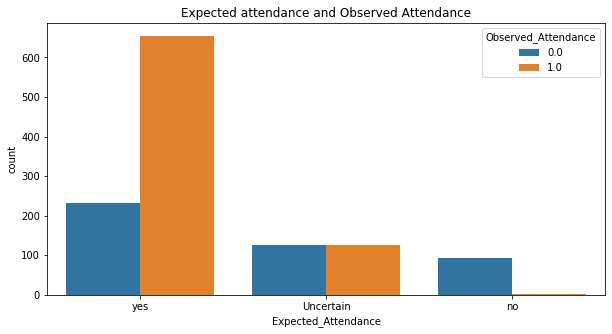

In [84]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.Expected_Attendance, hue = df.Observed_Attendance);
plt.title('Expected attendance and Observed Attendance');

In [85]:
#testing 'expected attendance as a single variable classifier'
tp, tn, fp, fn = 0, 0, 0, 0

for obs, exp in list(zip(df.Observed_Attendance,df.Expected_Attendance)):
    if obs == 0:
        if exp == 'no':
            tn+=1
        else:
            fp+=1
    else:
        if exp == 'yes':
            tp+=1
        else:
            fn+=1

accuracy = (tp + tn) / (tp+tn+fp+fn)
print('Accuracy using only expected attendance as a feature: {}'.format(accuracy))
    

Accuracy using only expected attendance as a feature: 0.6074918566775245


In [86]:
# Create dependent and independent sets
y = df.Observed_Attendance
#drop candidate ID too which is unique for each candidate and so provides no extra information
X = df.drop(['Observed_Attendance','Cand_ID'], axis =1)


We can encode each categorical variable (give each category a number) here. We don't need to one-hot encode yet, as this depends on the algorithm. We also do not need to scale data for decision trees, so we will not do so now.

In [87]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in range(X.shape[1]): 
    X[X.columns[i]] = le.fit_transform(X[X.columns[i]])


<a id='Classification'></a>

   ## Classification

<a id='DT'></a>

### Decision Tree

In [88]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import numpy as np 


clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(clf,X = X,y = y,cv=3,scoring='accuracy')
mean_dt_cv_score = dt_cv_score.mean()
print ('Mean Accuracy of Tree: {}'.format(mean_dt_cv_score))

Mean Accuracy of Tree: 0.6636551573339694


This is worse that just using expected attendance as a feature. But we need to tune the parameters. 

#### Hyperparameter tuning

Using gridsearch, we will find the best possible decision tree classifier.

In [89]:
dt_param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [4,5,6,7,8,9],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,3,4,5,6]
}

In [90]:
dt_grid_search = GridSearchCV(clf,param_grid=dt_param_grid,cv=3,scoring='accuracy');
dt_grid_search.fit(X, y);

In [91]:
dt_gs_testing_score = dt_grid_search.score(X, y)

print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Testing Score: 74.51%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 5}

We have added 11% to our accuracy using parameter search.  

Can we remove any features at this stage, before we one-hot encode for other algorithms (and thereby drastically increase the number of dimensions). 

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


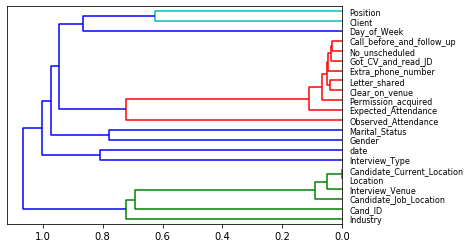

In [92]:
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr

corr = np.round(spearmanr(df).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method = 'average')
fig = plt.figure(figsize=(6,4))
dendrogram = hc.dendrogram(z, labels = df.columns, orientation='left',
                          leaf_font_size =8)
plt.show()


Candidate current location and Location seem to be highly correlated. We will assess performance of the decision tree again, after removing Location. 

In [93]:
#With Location
clf = DecisionTreeClassifier(criterion =  'gini',
                             max_depth =  7,
                             min_samples_leaf = 4,
                             min_samples_split = 10)
dt_cv_score = cross_val_score(clf,X = X,y = y,cv=3,scoring='accuracy')
mean_dt_cv_score = dt_cv_score.mean()
print ('Mean Accuracy of Tree with Location information: {}'.format(mean_dt_cv_score))

#Without Location
clf = DecisionTreeClassifier(criterion =  'gini',
                             max_depth =  7,
                             min_samples_leaf = 4,
                             min_samples_split = 10)
dt_cv_score = cross_val_score(clf,X = X.drop('Location',axis=1),y = y,cv=3,scoring='accuracy')
mean_dt_cv_score = dt_cv_score.mean()
print ('Mean Accuracy of Tree without Location information: {}'.format(mean_dt_cv_score))

Mean Accuracy of Tree with Location information: 0.691361043194784
Mean Accuracy of Tree without Location information: 0.6954300594350687


The accuracy varies each time this process is run, as we are randomly splitting train and test data. But it looks as though there is little impact on performance, so we will drop the Location feature for now. 

In [94]:
X.drop('Location',axis=1,inplace=True)

<a id='RF'></a>

### Random Forest

The accuracy for a vanilla Random Forest Classifier is only as high as our previous model. We will need to perform a parameter search here.

In [95]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = cross_val_score(rf_clf,X = X,y=y,cv=3).mean()
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))

Mean Cross Validation Score for Random Forest Classifier: 70.28%


In [96]:
rf_param_grid = {
    'n_estimators' : [10,30,100],
    'criterion' : ['gini','entropy'],
    'max_depth' : [1,3,6,9,20],
    'min_samples_split' : [2,4,8],
    'min_samples_leaf' : [1,2,3,5]
}

In [97]:
import time
start = time.time()
rf_grid_search = GridSearchCV(rf_clf,param_grid=rf_param_grid,cv=5)
rf_grid_search.fit(X, y)

print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

Testing Accuracy: 71.25%
Total Runtime for Grid Search on Random Forest Classifier: 158.3 seconds

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 10}


<a id='XG'></a>

### XGBoost

Let's try XGBoost too. It's time consuming, but may provide higher accuracy still.

In [98]:
import xgboost as xgb

In [99]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


clf = xgb.XGBClassifier()
mean_xg_cv_score = cross_val_score(clf,X = X,y=y,cv=3).mean()


print("Accuracy: {:.4}%".format(mean_xg_cv_score * 100))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 71.82%


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [100]:
param_grid = {
    "learning_rate": [0.01,0.1,1],
    'max_depth': [2,3,4,5,6],
    'min_child_weight': [0.5,1,3],
    'subsample': [0.5,0.8],
    'n_estimators': [10,100],
}

In [101]:
import warnings
warnings.filterwarnings("ignore")

grid_clf = GridSearchCV(estimator = clf,cv=3,param_grid=param_grid,scoring='accuracy',n_jobs=1)
grid_clf.fit(X, y)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

val_preds = grid_clf.predict(X)
val_accuracy = accuracy_score(val_preds,y)

print("")
print("Accuracy: {:.4}%".format(val_accuracy * 100))


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 4
min_child_weight: 0.5
n_estimators: 100
subsample: 0.8

Accuracy: 75.9%


<a id='KNN'></a>

### K Nearest Neighbours Classification

Next, let's try KNN. This is a distance-based classifier, so we will need to scale all features.

In [102]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

y = df.Observed_Attendance
X = df.drop('Observed_Attendance', axis =1)
X.drop('Location',axis=1,inplace=True)
X.drop(['date','Cand_ID'], axis = 1, inplace = True)

le = LabelEncoder()
for i in range(X.shape[1]): 
    X[X.columns[i]] = le.fit_transform(X[X.columns[i]])
    
#We need to scale all features as KNN relies on distance. 

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [103]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
KNN_cv_score = cross_val_score(clf_knn,X = X,y = y,cv=3,scoring='accuracy')
mean_KNN_cv_score = KNN_cv_score.mean()
print ('Mean Accuracy of Vanilla KNN: {}'.format(mean_KNN_cv_score))

Mean Accuracy of Vanilla KNN: 0.6750869660285845


In [104]:
param_grid_knn = {
    "n_neighbors": [3,5,7,9],
    'weights': ['uniform','distance'],
    'p': [2,3,4], #Minkowski distance
}

In [105]:
start = time.time()
knn_grid_search = GridSearchCV(clf_knn,param_grid=param_grid_knn,cv=3)
knn_grid_search.fit(X, y)

print("Testing Accuracy: {:.4}%".format(knn_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on KNN Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(knn_grid_search.best_params_))

Testing Accuracy: 68.08%
Total Runtime for Grid Search on KNN Classifier: 10.43 seconds

Optimal Parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


In [106]:
X.shape

(1228, 18)

Given we have 18 columns of data, let's try with PCA. We currently have a sparse feature space, so PCA may help. 

[0.42522438 0.61530678 0.69859425 0.76726618 0.82328214 0.87491612
 0.91617727 0.94374954 0.96534149 0.97631513 0.98701864 0.99125791
 0.99457255 0.99634888 0.99751353 0.99843853 0.99931238 1.        ]


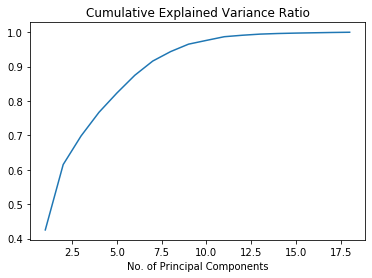

In [107]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(ratio)+1),ratio);
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('No. of Principal Components')
print(ratio)

In [108]:
#So let's go with 12 components, in which we capture 99% of the variance
pca = PCA(n_components=12)
pca.fit(X)
X_pca11 = pca.transform(X)

In [109]:
clf_knn = KNeighborsClassifier(weights='uniform',n_neighbors=9,p=2)
KNN_cv_score = cross_val_score(clf_knn,X = X_pca11,y = y,cv=3,scoring='accuracy')
mean_KNN_cv_score = KNN_cv_score.mean()
print ('Mean Accuracy of Optimised KNN with 11 Principal Components: {}'.format(mean_KNN_cv_score))

Mean Accuracy of Optimised KNN with 11 Principal Components: 0.6783429741387877


So PCA doesn't help in this case. 

<a id='NB'></a>

### Naive Bayes Classification

For Naive Bayes, we could use a multinomial classifier, but this doesn't support negative values. So we will one hot encode all values and use a binomial classifier. 

In [110]:
from sklearn.naive_bayes import BernoulliNB

y = df.Observed_Attendance
X = df.drop('Observed_Attendance', axis =1)
X.drop('Location',axis=1,inplace=True)
X.drop(['date','Cand_ID'], axis = 1, inplace = True)

#We will one hot encode for the SVM, as 'order' does not make sense for our indpendent variables
cols = X.columns
X[['Permission_acquired',
   'No_unscheduled', 
   'Call_before_and_follow_up', 
   'Extra_phone_number', 
   'Got_CV_and_read_JD',
   'Clear_on_venue',
   'Letter_shared','Day_of_Week']] = X[['Permission_acquired',
   'No_unscheduled', 
   'Call_before_and_follow_up', 
   'Extra_phone_number', 
   'Got_CV_and_read_JD',
   'Clear_on_venue',
   'Letter_shared', 'Day_of_Week']].astype('object')
X = pd.get_dummies(X[cols])
X.shape

(1228, 83)

In [111]:
clf_NB = BernoulliNB()
NB_cv_score = cross_val_score(clf_NB,X = X,y = y,cv=3,scoring='accuracy')
mean_NB_cv_score = NB_cv_score.mean()
print ('Mean Accuracy of Vanilla Bernoulli Naive Bayes: {}'.format(mean_NB_cv_score))

Mean Accuracy of Vanilla Bernoulli Naive Bayes: 0.7092671000059635


Accuracy rate of 71% with no optimisation.

In [112]:
param_grid_NB = {
    "alpha": [1e-10,0.5,1.0],
    'fit_prior': ['True','False']
}

In [113]:
import time
start = time.time()
NB_grid_search = GridSearchCV(clf_NB,param_grid=param_grid_NB,cv=3)
NB_grid_search.fit(X, y)

print("Testing Accuracy: {:.4}%".format(NB_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on KNN Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(NB_grid_search.best_params_))

Testing Accuracy: 70.93%
Total Runtime for Grid Search on KNN Classifier: 0.116 seconds

Optimal Parameters: {'alpha': 0.5, 'fit_prior': 'True'}


<a id='SVM'></a>

### Support Vector Machine Classification

In [114]:
from sklearn.svm import SVC

y = df.Observed_Attendance
X = df.drop('Observed_Attendance', axis =1)
X.drop('Location',axis=1,inplace=True)
X.drop(['date','Cand_ID'], axis = 1, inplace = True)

#We will one hot encode for the SVM, as 'order' does not make sense for our indpendent variables
X = pd.get_dummies(X)
X.head()

,Permission_acquired,No_unscheduled,Call_before_and_follow_up,Extra_phone_number,Got_CV_and_read_JD,Clear_on_venue,Letter_shared,Day_of_Week,Client_ANZ,Client_Astrazeneca,...,Interview_Venue_Cochin,Interview_Venue_Gurgaon,Interview_Venue_Hosur,Interview_Venue_Hyderabad,Interview_Venue_Noida,Expected_Attendance_Uncertain,Expected_Attendance_no,Expected_Attendance_yes,Marital_Status_Married,Marital_Status_Single
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0,0,...,0,0,1,0,0,0,0,1,0,1
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0,0,...,0,0,1,0,0,0,0,1,0,1
2,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,0,0,...,0,0,1,0,0,1,0,0,0,1
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,4.0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [115]:
clf_svm = SVC()
SVM_cv_score = cross_val_score(clf_svm,X = X,y = y,cv=3,scoring='accuracy')
mean_SVM_cv_score = SVM_cv_score.mean()
print ('Mean Accuracy of Vanilla SVM: {}'.format(mean_SVM_cv_score))


Mean Accuracy of Vanilla SVM: 0.7068340390005368


In [116]:
param_grid_svm = {"C" : np.linspace(.1, 1e6, num=11),
             "gamma" : np.linspace(10**-5, 5, num=11)}

In [117]:
start = time.time()
svm_grid_search = GridSearchCV(clf_svm,param_grid=param_grid_svm,cv=3, scoring='accuracy')
svm_grid_search.fit(X, y)

print("Testing Accuracy: {:.4}%".format(svm_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on SVM Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(svm_grid_search.best_params_))

Testing Accuracy: 70.68%
Total Runtime for Grid Search on SVM Classifier: 48.48 seconds

Optimal Parameters: {'C': 1000000.0, 'gamma': 1e-05}


<a id='Further_Work'></a>

# Further work

I have used accuracy to evaluate these algorithms. In a business environment, we would need to agree whether this is the correct metric, or whether false negatives and false positives should be treated differently. 

For example, if we were to say we want to reduce false positives i.e. we want fewer people we think are going to interview and then don't show. These people will particularly annoy employers! In order to do this, we would look at the ROC curve for the algorithms and aim to optimise for false positive rate.